## Pneumonia Deteciton with CNN

### Introduction

This project focuses on developing a deep learning model using convolutional neural networks (CNNs) to automate the detection of pneumonia from chest X-ray images. The dataset, sourced from Kaggle, contains labeled images categorized as "NORMAL" and "PNEUMONIA," and is organized into training, validation, and test sets.

The primary objective of this project is to design, train, and evaluate a CNN-based classifier capable of distinguishing between normal and pneumonia-affected X-rays with high accuracy, recall, and precision. The model’s performance will be assessed using key metrics: accuracy, recall, precision, and F1 score—to ensure a balanced approach to sensitivity and specificity, particularly given the critical nature of detecting pneumonia accurately. This project aims to create a reliable, automated tool that could support radiologists by enhancing diagnostic speed and accuracy, contributing to better clinical outcomes.

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

### Load Packages

In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

### Load Data

The dataset used in this project originates from the "Chest X-Ray Images (Pneumonia)" dataset available on Kaggle. This dataset contains 5,863 chest X-ray images organized into three main subsets: training, validation, and test sets. Each subset contains images labeled as either "NORMAL" (representing healthy lungs) or "PNEUMONIA" (indicating bacterial or viral pneumonia). The images are grayscale and of varying dimensions, typically resized for model input, with a standard input size of 256x256 pixels in this project. The images are also rescaled by 1./255 to be more beneficial to neural networks. A pixel with a value of 0 (black) remains as 0. A pixel with a value of 255 (white) becomes 1. A pixel with a value of 128 (gray) becomes 0.5.

The dataset is well-suited for binary classification tasks. Its structure allows for a robust training and evaluation process, facilitating the development of a reliable model for automated pneumonia detection.

In [3]:
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, 'train')
val_dir = os.path.join(current_dir, 'val')
test_dir = os.path.join(current_dir, 'test')

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20, zoom_range = 0.2)
# train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20, zoom_range = 0.2, horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train_data = train_datagen.flow_from_directory(train_dir, target_size = (256, 256), batch_size = 32, class_mode = 'binary')
val_data = val_datagen.flow_from_directory(val_dir, target_size = (256, 256), batch_size = 32, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#### Getting Test Data and Labels

In [6]:
test_gen = test_datagen.flow_from_directory(test_dir, target_size = (256, 256), batch_size = 32, class_mode = 'binary', shuffle = False)

test_data = []
test_labels = []

for _ in range(len(test_gen)):
    data, labels = test_gen.next()
    test_data.append(data)
    test_labels.append(labels)

test_data = np.vstack(test_data)
test_labels = np.concatenate(test_labels)

Found 624 images belonging to 2 classes.


### Exploratory Data Analysis

The exploratory data analysis (EDA) for this project provides an in-depth look at the structure, distribution, and quality of the chest X-ray images within the dataset, helping to guide the preprocessing and model building phases. Key steps in the EDA process include assessing the distribution of classes, visualizing image samples, and analyzing image properties.

#### Data Distribution

In [9]:
train_labels = list(train_data.class_indices.keys())
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))

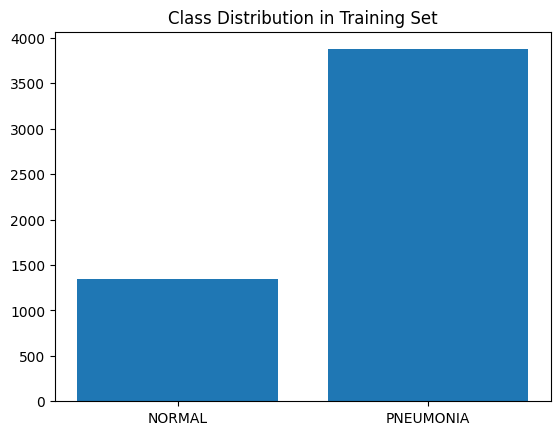

In [10]:
plt.bar(train_labels, [num_normal, num_pneumonia])
plt.title('Class Distribution in Training Set')
plt.show()

In [11]:
print(f'Number of Normal Cases: {num_normal}')
print(f'Number of Pneumonia Cases: {num_pneumonia}')

Number of Normal Cases: 1341
Number of Pneumonia Cases: 3875


Here, we can see that in the training data, there are 1341 normal images and 3875 pneumonia images.

#### Viewing Some Images

In [16]:
def plot_images(data):
    images, labels = next(data)
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Pneumonia' if labels[i] == 1 else 'Normal')
        plt.axis('off')
    plt.show()

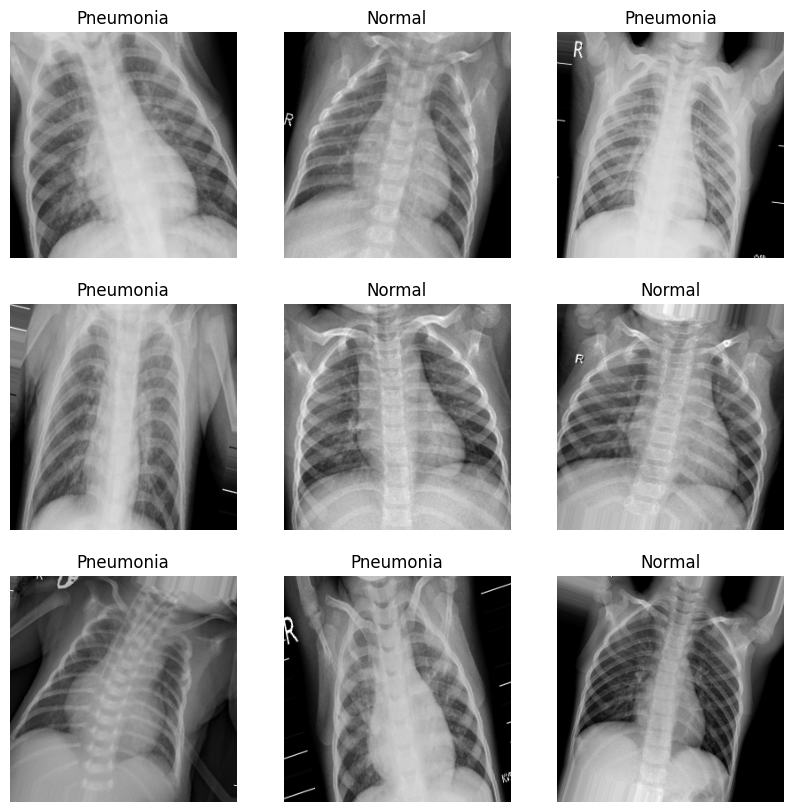

In [17]:
plot_images(train_data)

Representative images from each class are displayed to observe visual differences between normal and pneumonia-affected lungs. From a radiological diagnostic standpoint, a chest x-ray showing pneumonia would have white areas called infiltrates, often indicating infection. Other complications of pneumonia may also be seen on an x-ray such as pleural effusions or abscesses (Mount Sinai).

https://www.mountsinai.org/health-library/report/pneumonia

#### Plotting Pixel Intensity

In [18]:
# Extract images and labels
def plot_pixels(data):
    images, labels = next(data)
    
    # Plot pixel intensity distribution for each class
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Pixel Intensity Distribution for NORMAL and PNEUMONIA Classes')
    
    for class_label, ax in zip([0, 1], axs):
        # Select images by class label
        class_images = images[labels == class_label]
        class_images_flat = class_images.flatten()  # Flatten images to a 1D array of pixel values
        
        # Plot histogram of pixel intensities
        ax.hist(class_images_flat, bins=50, color='blue' if class_label == 0 else 'red', alpha=0.7)
        ax.set_title('NORMAL' if class_label == 0 else 'PNEUMONIA')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_xlim(0, 1)
    
    plt.show()

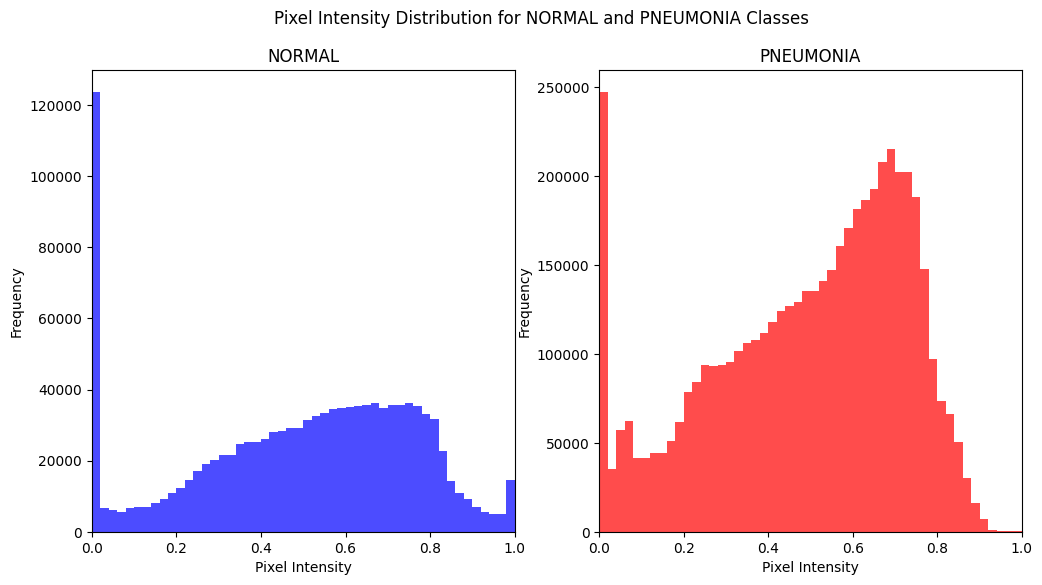

In [19]:
plot_pixels(train_data)

Plotting the distribution of the standardized pixel intensity for these grayscale images brings some insight into contrast and brightness levels. Black pixels have an intensity of 0, while white pixels have an intensity of 1. X-rays are inherently black and white images because they represent varying densities of tissues. Dense structures like bones appear as white, while less dense areas like fluid, appear darker. By examining pixel intensities, we can see that x-rays indicating pneumonia have higher frequencies of higher pixel intensity, meaning more structures that appear white. Understanding pixel intensity patterns helps to guide the model training by showing the pixel characteristics that differentiate normal and pneumonia x-rays.

### Building CNN Models

In order to create and train this classifier to detect pneumonia and distinguish between normal x-rays, we will first start off with a simple convoluted neural network and make improvements and changes with each iteration thereafter.

For the ease of visualizing training and validation results as well as for the ease of model evalutation, functions are created to easily facilitate the two processes for each model iteration.

#### Model 1

In [61]:
model_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_1 = model_1.fit(train_data, epochs = 5, validation_data = val_data)

Epoch 1/5
163/163 [==============================] - 44s 268ms/step - loss: 9.6306 - accuracy: 0.5301 - val_loss: 1.1224 - val_accuracy: 0.5625
Epoch 2/5
163/163 [==============================] - 44s 270ms/step - loss: 0.9302 - accuracy: 0.7249 - val_loss: 5.1151 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 44s 270ms/step - loss: 7.1493 - accuracy: 0.6436 - val_loss: 5.6220 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 45s 278ms/step - loss: 4.6242 - accuracy: 0.6522 - val_loss: 4.2216 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 45s 275ms/step - loss: 2.8185 - accuracy: 0.6555 - val_loss: 2.5131 - val_accuracy: 0.5625


#### Funcion to Visualize Training Results

In [95]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (12, 4))

    #accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    #loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

#### Function for Model Evaluation

In [90]:
def evaluate_model(model, test_data, test_labels):
    pred = model.predict(test_data)
    pred_labels = (pred > 0.5).astype(int).flatten()

    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)
    report = classification_report(test_labels, pred_labels, target_names = ["Normal", "Pneumonia"])

    print(f'Accuracy: {acc:.2f}')
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print("\nClassification Report:")
    print(report)

    #confusion matrix
    cm = confusion_matrix(test_labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal", "Pneumonia"])
    cm_display.plot()
    plt.title('Confusion Matrix')
    plt.show()

    #roc curve
    fpr, tpr, _ = roc_curve(test_labels, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'blue', label = f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()

    #auc pc curve (precision recall)
    prec_curve, rec_curve, _ = precision_recall_curve(test_labels, pred)
    pr_auc = auc(rec_curve, prec_curve)
    plt.figure(figsize = (8, 6))
    plt.plot(rec_curve, prec_curve, color = 'green', label = f'Precision-Recall Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc = 'lower left')
    plt.show()


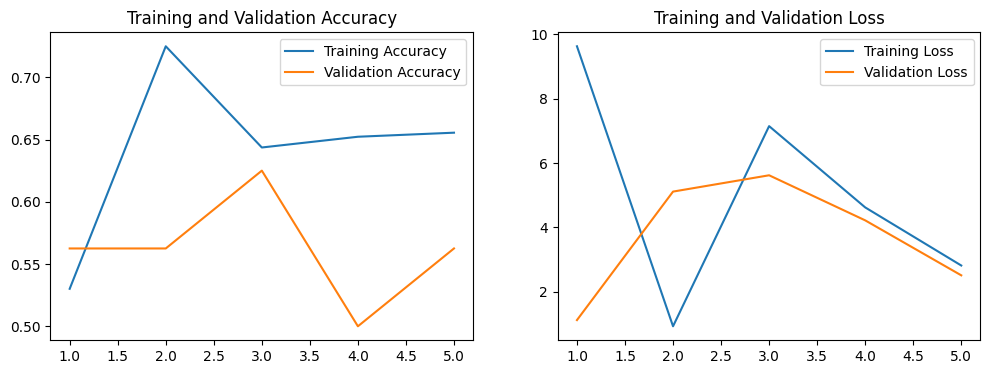

In [96]:
plot_history(history_1)

20/20 [==============================] - 0s 12ms/step
Accuracy: 0.55
Precision: 0.67
Recall: 0.56
F1 Score: 0.61

Classification Report:
              precision    recall  f1-score   support

      Normal       0.42      0.54      0.47       234
   Pneumonia       0.67      0.56      0.61       390

    accuracy                           0.55       624
   macro avg       0.54      0.55      0.54       624
weighted avg       0.58      0.55      0.56       624



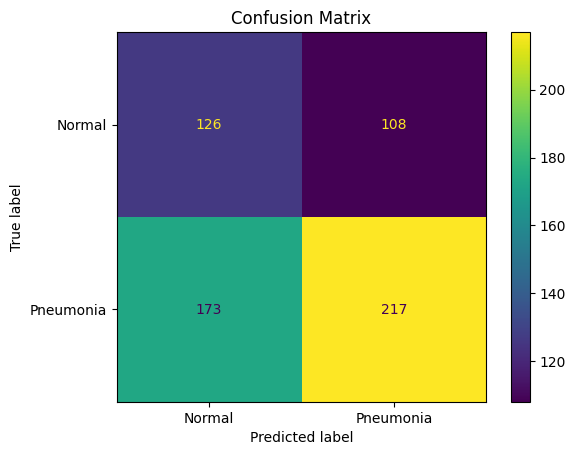

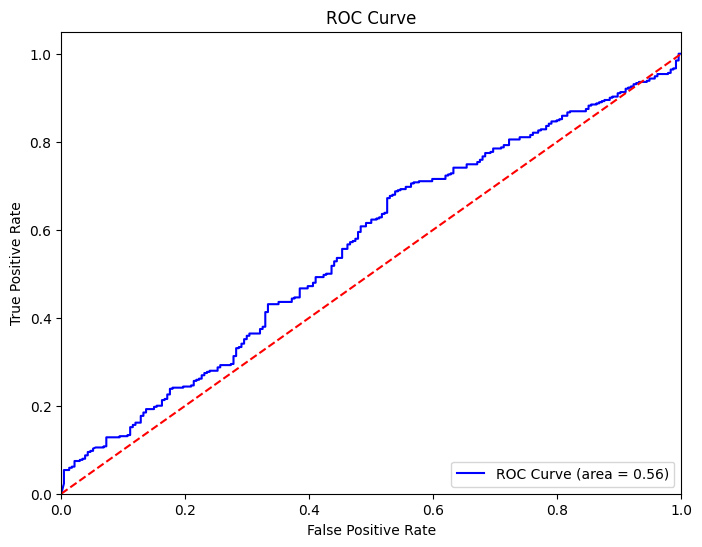

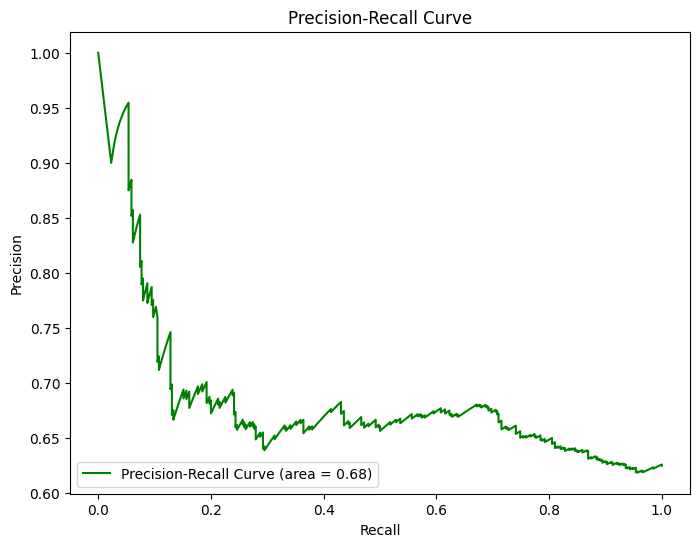

In [91]:
evaluate_model(model_1, test_data, test_labels)

The first model gives pretty poor results, which makes sense since it was trained on a fairly simple neural network. Model 1 gave an accuracy of 55% and recall of 56% overall, and when looking at the same metrics by class (normal vs pneumonia), the results were not much better.

#### Model 2

Model 2 differs from its predecessor by doubling the number of inputs in each Conv2D layer, and adds another one with 256 inputs. The dense layer also matches the number of inputs from Model 2's previous layer.

In [64]:
model_2 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_2 = model_2.fit(train_data, epochs = 5, validation_data = val_data)

Epoch 1/5
163/163 [==============================] - 45s 273ms/step - loss: 0.8630 - accuracy: 0.7241 - val_loss: 0.5548 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 45s 276ms/step - loss: 1.1590 - accuracy: 0.7974 - val_loss: 0.7191 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 45s 275ms/step - loss: 0.3223 - accuracy: 0.8735 - val_loss: 0.3729 - val_accuracy: 0.8125
Epoch 4/5
163/163 [==============================] - 45s 273ms/step - loss: 0.3324 - accuracy: 0.8708 - val_loss: 1.4667 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 45s 274ms/step - loss: 0.2892 - accuracy: 0.8878 - val_loss: 1.3070 - val_accuracy: 0.6250


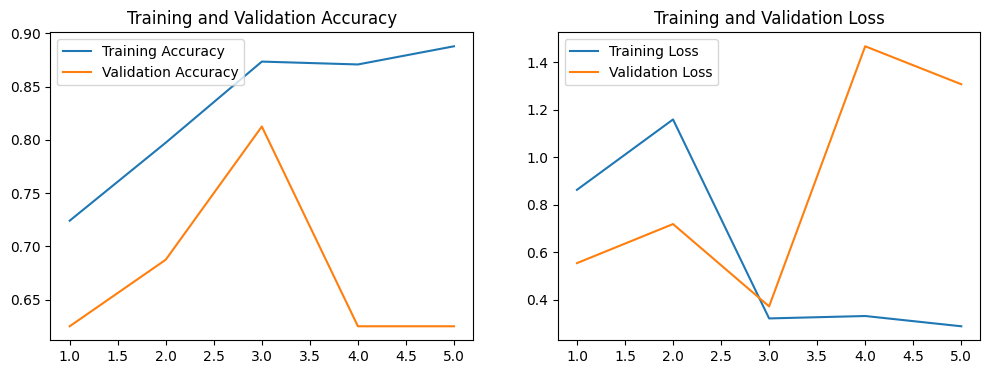

In [97]:
plot_history(history_2)

20/20 [==============================] - 1s 25ms/step
Accuracy: 0.71
Precision: 0.69
Recall: 0.99
F1 Score: 0.81

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.24      0.39       234
   Pneumonia       0.69      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.62      0.60       624
weighted avg       0.79      0.71      0.65       624



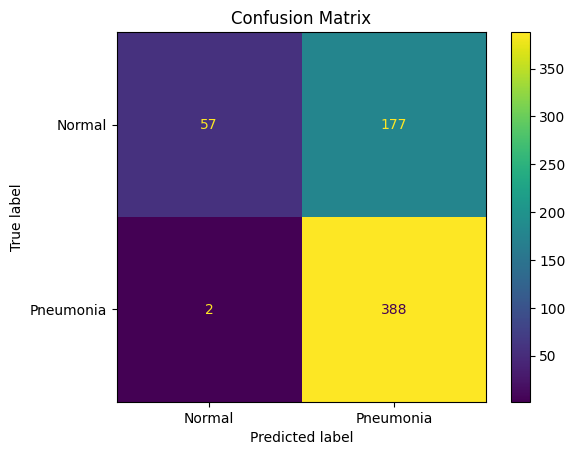

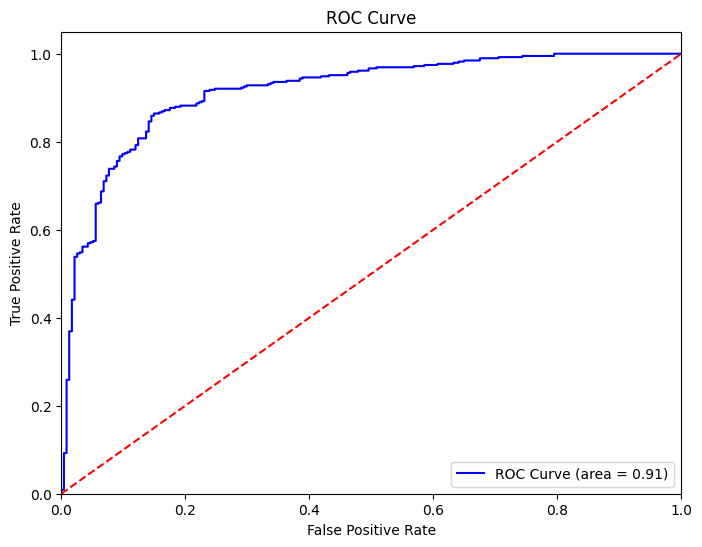

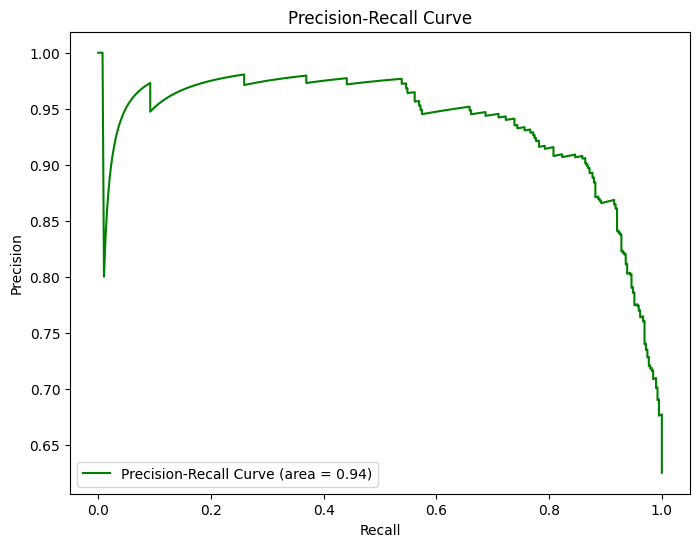

In [92]:
evaluate_model(model_2, test_data, test_labels)

#### Model 3

In [67]:
model_3= models.Sequential([
    layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid')
])

model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_3 = model_3.fit(train_data, epochs = 5, validation_data = val_data)

Epoch 1/5
163/163 [==============================] - 66s 398ms/step - loss: 5.2776 - accuracy: 0.6315 - val_loss: 2.1535 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 69s 424ms/step - loss: 10.2384 - accuracy: 0.6403 - val_loss: 18.5360 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 68s 418ms/step - loss: 11.3832 - accuracy: 0.7007 - val_loss: 14.0270 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 66s 406ms/step - loss: 6.0180 - accuracy: 0.7876 - val_loss: 3.3684 - val_accuracy: 0.7500
Epoch 5/5
163/163 [==============================] - 66s 402ms/step - loss: 4.3060 - accuracy: 0.8181 - val_loss: 2.1897 - val_accuracy: 0.8750


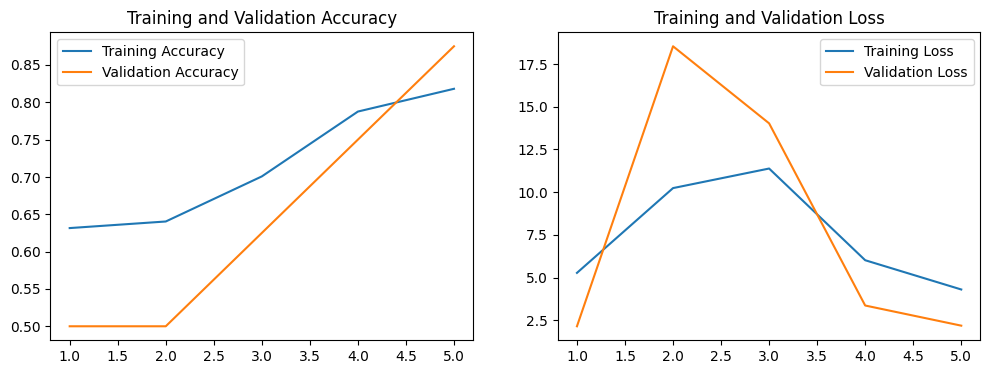

In [98]:
plot_history(history_3)

20/20 [==============================] - 1s 74ms/step
Accuracy: 0.80
Precision: 0.92
Recall: 0.75
F1 Score: 0.82

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.88      0.77       234
   Pneumonia       0.92      0.75      0.82       390

    accuracy                           0.80       624
   macro avg       0.80      0.82      0.79       624
weighted avg       0.83      0.80      0.80       624



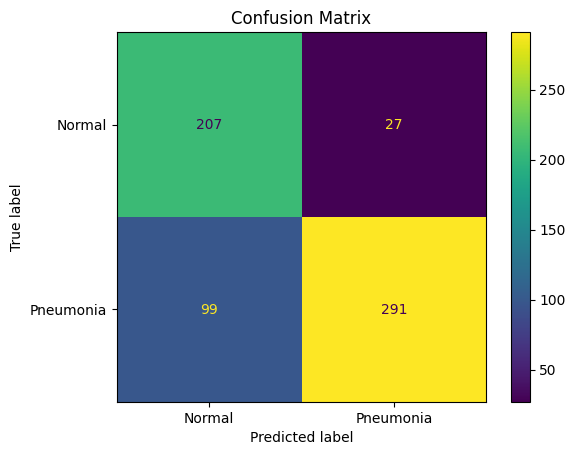

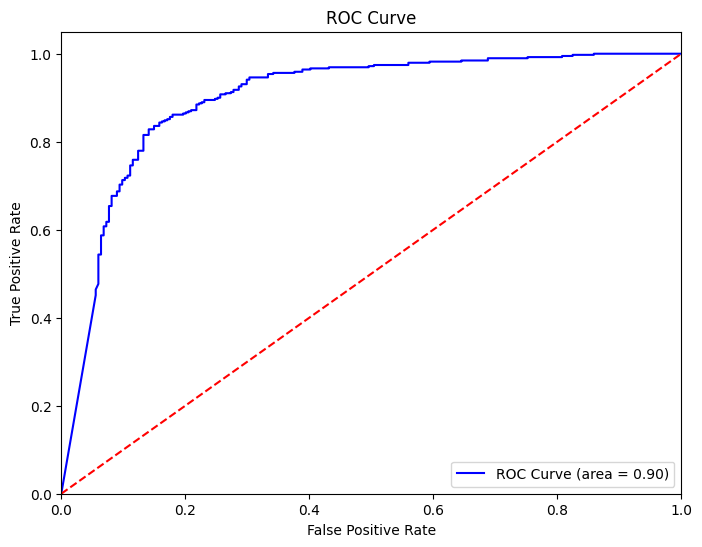

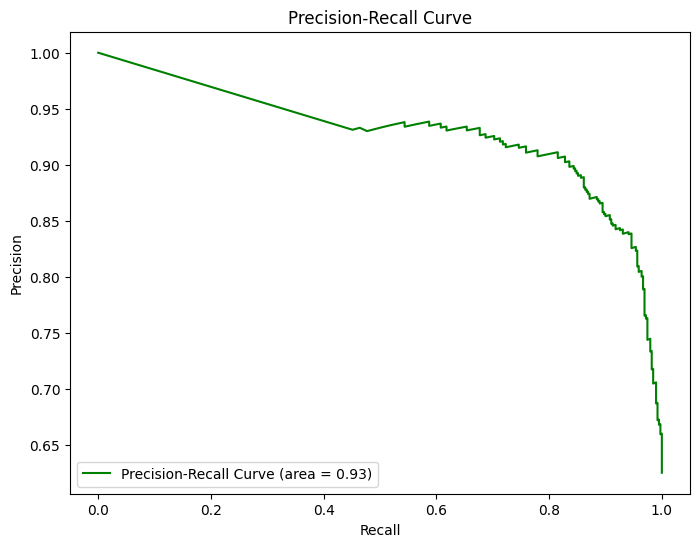

In [93]:
evaluate_model(model_3, test_data, test_labels)

#### Model 4: Model 2 with More Epochs

In [69]:
model_4 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_4 = model_4.fit(train_data, epochs = 10, validation_data = val_data)

Epoch 1/10
163/163 [==============================] - 45s 272ms/step - loss: 0.7352 - accuracy: 0.7818 - val_loss: 0.4266 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 44s 272ms/step - loss: 0.2665 - accuracy: 0.8953 - val_loss: 0.4763 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 45s 273ms/step - loss: 0.2983 - accuracy: 0.8777 - val_loss: 0.7126 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 45s 274ms/step - loss: 0.3029 - accuracy: 0.8758 - val_loss: 0.7941 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 45s 274ms/step - loss: 0.2409 - accuracy: 0.9011 - val_loss: 0.7715 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 45s 273ms/step - loss: 0.2534 - accuracy: 0.9020 - val_loss: 0.4637 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 45s 273ms/step - loss: 0.2281 - accuracy: 0.9122 - val_loss: 0.8938 - val_ac

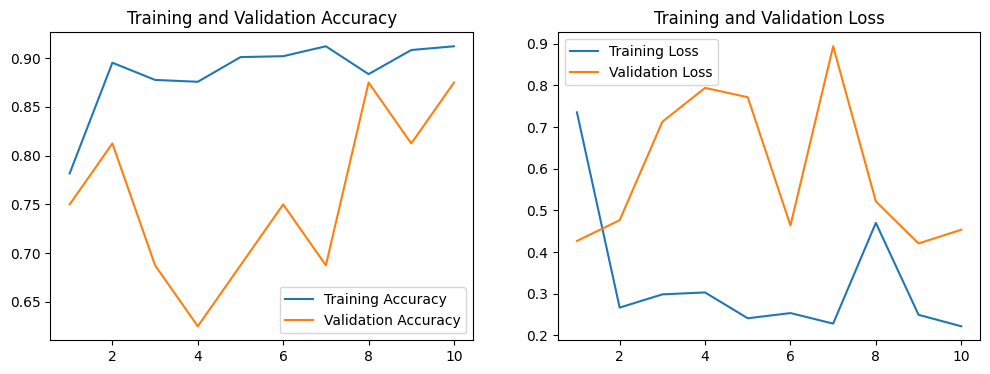

In [99]:
plot_history(history_4)

20/20 [==============================] - 1s 26ms/step
Accuracy: 0.81
Precision: 0.78
Recall: 0.98
F1 Score: 0.87

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.53      0.68       234
   Pneumonia       0.78      0.98      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.76      0.77       624
weighted avg       0.84      0.81      0.80       624



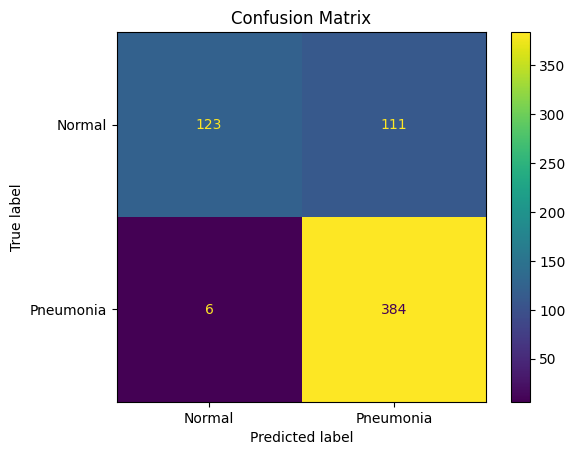

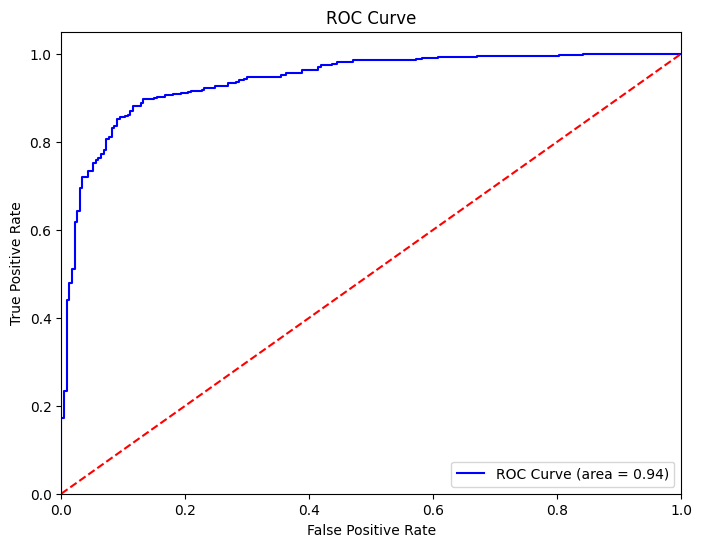

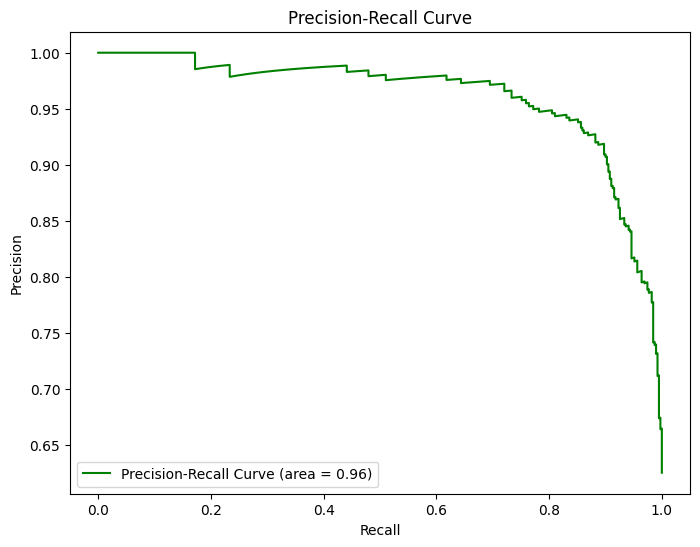

In [94]:
evaluate_model(model_4, test_data, test_labels)

In [106]:
def evaluate_model_new(model, test_data, test_labels):
    pred = model.predict(test_data)
    pred_labels = (pred > 0.7).astype(int).flatten()

    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)
    report = classification_report(test_labels, pred_labels, target_names = ["Normal", "Pneumonia"])

    print(f'Accuracy: {acc:.2f}')
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print("\nClassification Report:")
    print(report)

    #confusion matrix
    cm = confusion_matrix(test_labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal", "Pneumonia"])
    cm_display.plot()
    plt.title('Confusion Matrix')
    plt.show()

    #roc curve
    fpr, tpr, _ = roc_curve(test_labels, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'blue', label = f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()

    #auc pc curve (precision recall)
    prec_curve, rec_curve, _ = precision_recall_curve(test_labels, pred)
    pr_auc = auc(rec_curve, prec_curve)
    plt.figure(figsize = (8, 6))
    plt.plot(rec_curve, prec_curve, color = 'green', label = f'Precision-Recall Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc = 'lower left')
    plt.show()


### Model 5: Adding L2 Regularizer

In [101]:
model_5 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (256, 256, 3), kernel_regularizer = l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu', kernel_regularizer = l2(0.001)),
    layers.Dense(1, activation = 'sigmoid')
])

model_5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_5 = model_5.fit(train_data, epochs = 10, validation_data = val_data)

Epoch 1/10
163/163 [==============================] - 47s 285ms/step - loss: 1.0493 - accuracy: 0.7789 - val_loss: 0.7407 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 45s 273ms/step - loss: 0.4526 - accuracy: 0.8746 - val_loss: 1.1199 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 45s 273ms/step - loss: 0.3717 - accuracy: 0.8986 - val_loss: 0.9558 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 45s 275ms/step - loss: 0.3395 - accuracy: 0.9057 - val_loss: 0.8362 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 45s 274ms/step - loss: 0.3241 - accuracy: 0.9043 - val_loss: 0.6068 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 45s 275ms/step - loss: 0.3139 - accuracy: 0.9109 - val_loss: 1.1257 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 45s 274ms/step - loss: 0.3041 - accuracy: 0.9155 - val_loss: 0.8766 - val_ac

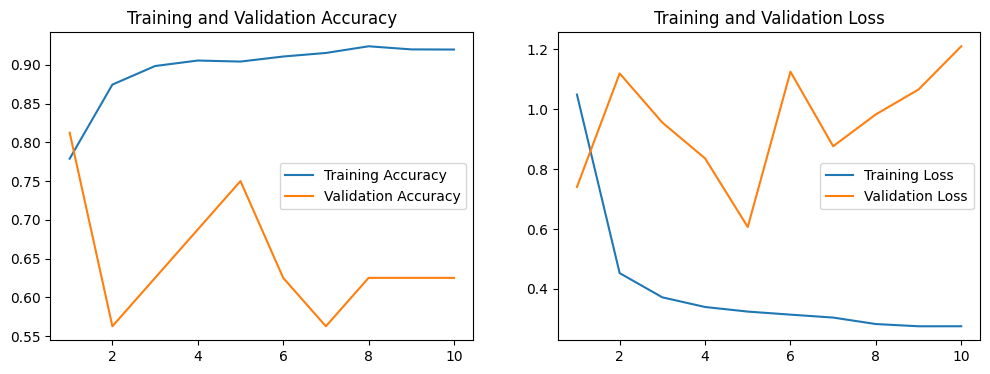

In [102]:
plot_history(history_5)

20/20 [==============================] - 1s 27ms/step
Accuracy: 0.80
Precision: 0.77
Recall: 0.98
F1 Score: 0.86

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.50      0.66       234
   Pneumonia       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.76       624
weighted avg       0.84      0.80      0.78       624



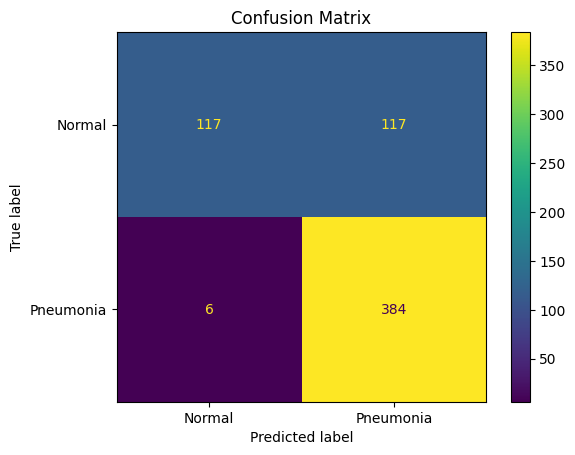

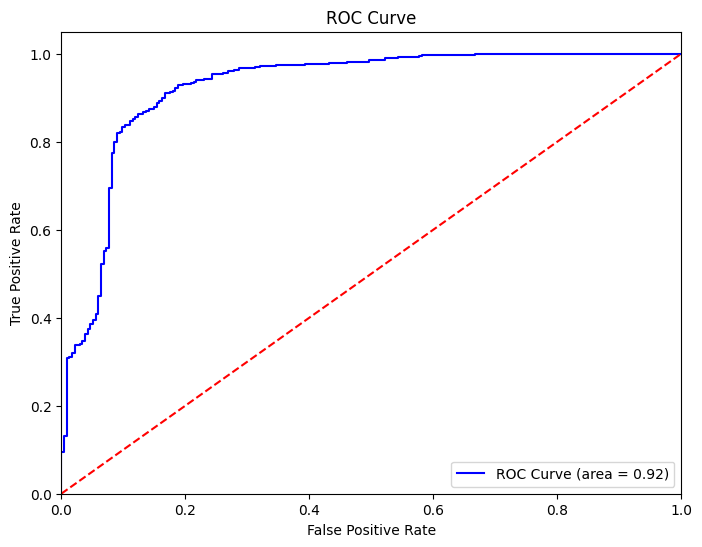

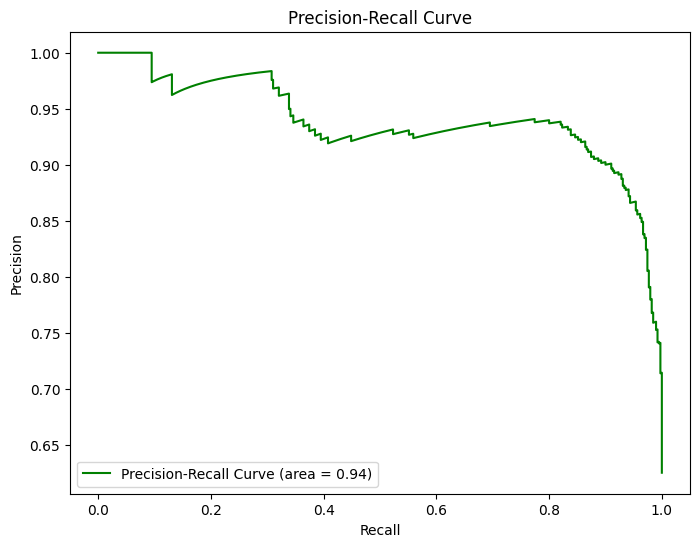

In [103]:
evaluate_model(model_5, test_data, test_labels)

### Summary of Results

In developing a robust model for pneumonia detection from chest X-ray images, an iterative approach was adopted to optimize performance. Initially, the model was simple, with only a few convolutional and max-pooling layers to extract features, along with a small number of epochs (5) for training. This provided a baseline but was limited in its ability to capture the complex patterns in the data. Gradually, the model complexity was increased by adding more convolutional layers, which enabled the network to learn more detailed features, essential for distinguishing between normal and pneumonia cases. Max-pooling layers were added after each convolutional layer to reduce spatial dimensions, control the model size, and help with overfitting. Additionally, we extended the training epochs from 5 to 10, allowing the model to learn better from the data.

In the final and best performing model, L2 regularization was applied to each convolutional layer, adding a penalty for large weights. This regularization technique discourages excessive reliance on any single feature by penalizing large weight values, resulting in a model that is less prone to overfitting. With L2 regularization, the model achieved a better balance between fitting the training data well and maintaining generalizability to unseen data. This careful tuning led to our final and best-performing model, which achieved an accuracy of 0.80, precision of 0.77, recall of 0.98, and an F1 score of 0.86.

### Final Model Evaluation and Clinical Significance

From a machine learning standpoint, the high recall of 0.98 indicates the model's strong ability to correctly identify pneumonia cases, making it highly sensitive and reducing the risk of missing a diagnosis. However, with a precision of 0.77, the model is less effective at avoiding false positives, occasionally misclassifying normal cases as pneumonia. The F1 score of 0.86 demonstrates a good balance between precision and recall, but with room for improvement, especially in precision. From a clinical perspective, this model's high recall is valuable for pneumonia detection, as it minimizes the risk of false negatives, ensuring that most patients with pneumonia are identified. However, improving precision is important to reduce unnecessary follow-up tests for patients falsely identified as having pneumonia.

### Future Improvements

To further improve this model, several strategies can be explored. Increasing the dataset size, especially for normal cases, would help balance the data and likely improve precision. Fine-tuning the L2 regularization strength could enhance generalization while retaining the model's sensitivity. Additionally, implementing techniques such as dropout, data augmentation, or ensembling with other models could provide further gains in accuracy and precision. Finally, more advanced architectures like pre-trained models or deeper networks could capture finer patterns, potentially leading to a more clinically reliable tool for pneumonia diagnosis.






